# 3-Layer NN for Classifciation(Only Python)

## 1. Train데이터, Test데이터 로드하기
<data's shape>

- train_images: 60000 * 1 * 28 * 28

- train_labels: 60000 * 10

- test_images: 10000 * 1 * 28 * 28

- test_labels: 10000 * 10

In [13]:
from dataloader import Dataloader
import numpy as np

train_loader = Dataloader(path="./", is_train = True, shuffle=True)
test_loader = Dataloader(path="./", is_train = False, shuffle=True)

train_images= train_loader.images
train_labels = train_loader.labels
test_images = test_loader.images
test_labels = test_loader.labels

## 2. 이미지를 1차원으로 평탄화하기
1 * 28 * 28 이미지를 784 * 1 벡터로 변환하기(flatten)

x_train's shape: (784, 60000)

x_test's shape: (784, 10000)

y_train's shape: (10, 60000)

y_test's shape: (10, 10000)

In [14]:
train_x_flatten = train_images.reshape(train_images.shape[0], -1).T
test_x_flatten = test_images.reshape(test_images.shape[0], -1).T

# normalization: 0과 1사이로 정규화 시키기
x_train = train_x_flatten/255.
x_test = test_x_flatten/255.

y_train = train_labels.T
y_test = test_labels.T

## 3. Train Pipeline과 Test Pipeline 구현

In [15]:
class linear():
    def __init__(self,learning_rate, input_size, output_size):
        # 가중치 초기화하기
        self.learning_rate = learning_rate
        self.weight = np.random.randn(output_size, input_size)*0.01
        self.bias = np.zeros((output_size,1))

    def forward(self, input):
        return np.dot(self.weight, input) + self.bias
    
    def backward(self, input, output_gradient):
        input_gradient = np.dot(self.weight.T ,output_gradient)
        weight_gradient = np.dot( output_gradient, input.T)
        bias_gradient = np.sum(output_gradient, axis=1, keepdims=True)

        self.weight = self.weight - self.learning_rate * weight_gradient
        self.bias = self.bias - self.learning_rate * bias_gradient

        return input_gradient
    
class ReLU():
    def forward(self, input):
        return np.maximum(0, input)

    def backward(self, input, output_gradient):
        grad = input > 0
        return grad * output_gradient

class NN():
    def __init__(self,learning_rate):
        self.inputs=[0]*5
        self.linear1 = linear(learning_rate,784, 256)
        self.linear2 = linear(learning_rate,256, 128)
        self.linear3 = linear(learning_rate,128, 10)
        self.relu1=ReLU()
        self.relu2=ReLU()

    def forward(self, input):
        self.inputs[0] = input
        self.inputs[1] = self.linear1.forward(self.inputs[0])
        self.inputs[2] = self.relu1.forward(self.inputs[1])
        self.inputs[3] = self.linear2.forward(self.inputs[2])
        self.inputs[4] = self.relu2.forward(self.inputs[3])
        output = self.linear3.forward(self.inputs[4])
        return output    
        
    def backward(self, output_gradient):
        inputs = self.inputs
        output_gradient = self.linear3.backward(inputs[4], output_gradient)
        output_gradient = self.relu2.backward(inputs[3], output_gradient)
        output_gradient = self.linear2.backward(inputs[2], output_gradient)
        output_gradient = self.relu2.backward(inputs[1], output_gradient)
        output_gradient = self.linear1.backward(inputs[0], output_gradient)

In [16]:
def SoftMax(output):
    output -= np.max(output, axis=0, keepdims=True)
    exp_output = np.exp(output)
    softmax_values = exp_output / np.sum(exp_output, axis=0, keepdims=True)
    return softmax_values

class CE_Loss():
    def forward(y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-15, 1-1e-15)  # log값이 0이 되어 발산하는 거 방지
        loss = -np.sum(y_true*np.log(y_pred), axis=0)
        return np.mean(loss)  # 그냥 loss 출력해도 되지만 epoch당 loss를 알아보기 위해서
    
    def backward(y_pred, y_true):
        dz = y_pred-y_true
        return dz

## 4. Train Pipeline과 Test Pipeline 구현

In [18]:
def NN_train(model, x_train, y_train, batch_size, train_loss):
    num_iters = x_train.shape[1] // batch_size

    indices = np.random.permutation(x_train.shape[1])
    for i in range(num_iters):
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        x_batch = x_train[:, batch_indices]
        y_batch = y_train[:, batch_indices]
        
        # forward하면서 node값 구하기
        output = model.forward(x_batch)
        # softmax를 이용해 output을 확률값으로 변환
        y_pred = SoftMax(output)
        # Cross entropy loss 계산
        loss = CE_Loss.forward(y_pred, y_batch)
        if i==num_iters//2:
            train_loss.append(loss)

        # back propagation을 하기 위해 전체 loss를 output을 미분
        output_gradient = CE_Loss.backward(y_pred,y_batch)
        # back_propagation을 하면서 weight업데이트
        model.backward(output_gradient)

def NN_test(model, x_test, y_test, test_loss):
    y_pred=SoftMax(model.forward(x_test))
    loss = CE_Loss.forward(y_pred, y_test)
    test_loss.append(loss)
    
    correct_count = np.sum(np.argmax(y_pred,axis=0)==np.argmax(y_test, axis=0))
    accuracy = correct_count/x_test.shape[1]
    return accuracy  

## 5. 모델 학습하기

In [19]:
# Hyper parameter 정의

batch_size = 100
epochs = 100
learning_rate = 0.001
model = NN(learning_rate)

train_loss = []
test_loss = []

for i in range(epochs):
    NN_train(model, x_train, y_train, batch_size, train_loss)
    print(i+1,'Epoch Finished', end = '\t')
    print(f"Accuracy : {round(100*NN_test(model, x_test, y_test,test_loss),2)}%", end='\t')
    print(f"train loss: {round(train_loss[i],4)} test loss: {round(test_loss[i],4)}")

1 Epoch Finished	Accuracy : 86.59%	train loss: 1.1886 test loss: 0.4533
2 Epoch Finished	Accuracy : 91.87%	train loss: 0.3716 test loss: 0.2777
3 Epoch Finished	Accuracy : 93.99%	train loss: 0.2039 test loss: 0.2001
4 Epoch Finished	Accuracy : 95.5%	train loss: 0.1196 test loss: 0.1513
5 Epoch Finished	Accuracy : 96.22%	train loss: 0.0603 test loss: 0.1293
6 Epoch Finished	Accuracy : 96.92%	train loss: 0.0923 test loss: 0.1066
7 Epoch Finished	Accuracy : 96.71%	train loss: 0.0766 test loss: 0.1085
8 Epoch Finished	Accuracy : 97.26%	train loss: 0.1228 test loss: 0.0893
9 Epoch Finished	Accuracy : 97.33%	train loss: 0.1198 test loss: 0.0898
10 Epoch Finished	Accuracy : 97.35%	train loss: 0.0534 test loss: 0.091
11 Epoch Finished	Accuracy : 97.58%	train loss: 0.0188 test loss: 0.0802
12 Epoch Finished	Accuracy : 97.19%	train loss: 0.0345 test loss: 0.0931
13 Epoch Finished	Accuracy : 97.64%	train loss: 0.0243 test loss: 0.0767
14 Epoch Finished	Accuracy : 97.78%	train loss: 0.024 test los

# <결과물>

## Result1. Loss graph 그리기

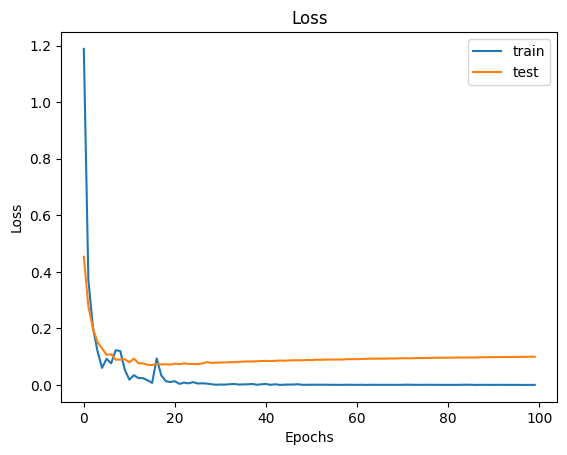

In [20]:
import matplotlib.pyplot as plt
# loss 그래프
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Result2. confusion matrix 그리기

(10000, 10)
[7 2 1 ... 4 5 6]
(10000,)


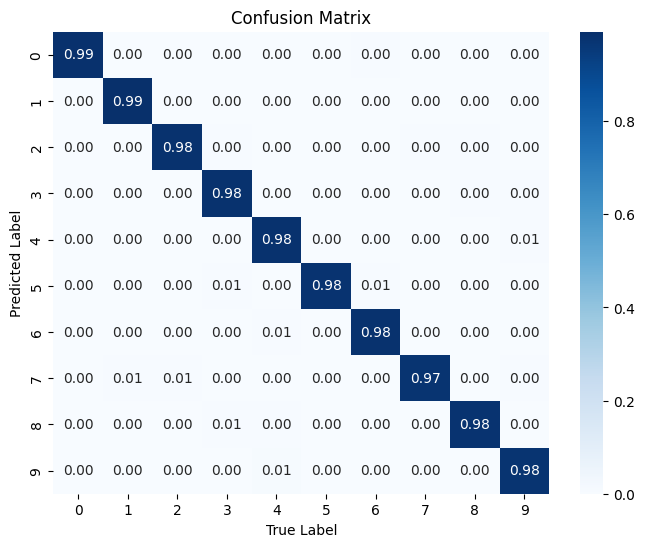

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 예측값 생성
y_pred=SoftMax(model.forward(x_test)).T
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
# Confusion Matrix 생성 및 정규화
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('True Label')  
plt.ylabel('Predicted Label')  
plt.title('Confusion Matrix')
plt.show()


## Result3-1. Top3 images 뽑아내기

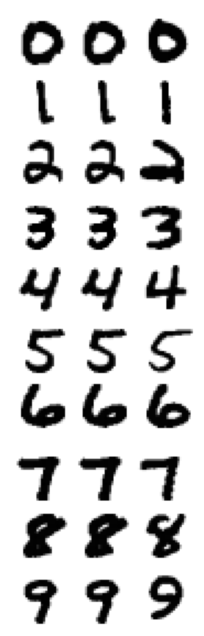

In [24]:
top3_data = [[] for _ in range(10)]

for i in range(len(y_pred)):
    for j in range(10):
        if len(top3_data[j])<3:
            top3_data[j].append((i,y_pred[i][j]))
        else:
            for k in range(3):
                if top3_data[j][k][1]<y_pred[i][j]:
                    top3_data[j].remove(min(top3_data[j], key=lambda x: x[1]))
                    top3_data[j].append((i,y_pred[i][j]))
                else:
                    continue

top3_sort = [[] for _ in range(10)]
for i in range(10):
    top3_sort[i] = sorted(top3_data[i], key= lambda x: x[1], reverse=True)

final_combined_image = None
for i in range(10):
    image1 = 1 - test_loader.images[top3_sort[i][0][0]].reshape(28,28)
    image2 = 1 - test_loader.images[top3_sort[i][1][0]].reshape(28,28) 
    image3 = 1 - test_loader.images[top3_sort[i][2][0]].reshape(28,28) 
    combined_image = np.hstack((image1, image2, image3))
    if final_combined_image is None:
        final_combined_image = combined_image
    else:
        # 기존의 final_combined_image에 새로 연결된 이미지를 세로로 추가
        final_combined_image = np.vstack((final_combined_image, combined_image))

    # 결과 출력
plt.figure(figsize=(8, 8))
plt.imshow(final_combined_image, cmap='gray')
plt.axis('off')  # 축 숨기기
plt.show()



## Result3-2. Top3 images에 대한 확률 뽑아내기

In [25]:
for i in range(10):
    print(f"{round(top3_sort[i][0][1]*100,1)}%, {round(top3_sort[i][1][1]*100,1)}%, {round(top3_sort[i][2][1]*100,1)}%")
    print()

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

